In [1]:
import sys
import os
from openai import OpenAI
import time

# Get the parent directory of the current script
parent_dir = os.path.abspath("..")  # Move one level up
sibling1_path = os.path.join(parent_dir, "server")
# Add sibling directory to sys.path
sys.path.append(sibling1_path)
os.chdir("/Users/samytlee/Documents/projects/TaskDecomposition")
import server.custom_types as custom_types
import server.executor as executor
import json
from tqdm import tqdm
import concurrent
import tiktoken
api_key = open("evaluation_experiments/openai_api_key", "r").read().strip()

def request_gpt(messages, model, api_key, format=None):
    openai = OpenAI(api_key=api_key)
    try:
        if format == "json":
            response = openai.chat.completions.create(
                    model=model,
                    messages=messages,
                    response_format={"type": "json_object"},
                )
            
            try:
                response = json.loads(response.choices[0].message.content)
                return response
            except json.JSONDecodeError as e:
                print("JSON Decode Error")
                print(e)
                time.sleep(5)
                return request_gpt(messages, model, api_key, format)

        else:
            response = openai.chat.completions.create(
                model=model, messages=messages
            )
        return response.choices[0].message.content
    except Exception as e:
        print(e)
        time.sleep(5)
        pass
        # return request_gpt(messages, model, api_key, format)

def multithread_embedding(client, texts):
    l = len(texts)
    with tqdm(total=l) as pbar:
        executor = concurrent.futures.ThreadPoolExecutor(max_workers=100)
        futures = [executor.submit(get_embedding, client, text) for text in texts]
        for _ in concurrent.futures.as_completed(futures):
            pbar.update(1)
    concurrent.futures.wait(futures)
    return [future.result() for future in futures]

# def get_embedding(client, text, model="text-embedding-3-small"):
def get_embedding(client, text, model="text-embedding-ada-002"):
    enc = tiktoken.encoding_for_model(model)
    # print("tokens: ", len(enc.encode(text)), len(enc.encode(text)) > 8191)
    while len(enc.encode(text)) > 8191:
        text = text[:-100]
        print("truncated: ", len(enc.encode(text)))
    try:
        return client.embeddings.create(input=[text], model=model).data[0].embedding
    except Exception as e:
        print(e)
        return get_embedding(client, text, model)
 

/Users/samytlee/opt/anaconda3/envs/task_decomposition_311/lib/python3.11/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'orm_mode' has been renamed to 'from_attributes'
  warnings.warn(message, UserWarning)
/Users/samytlee/opt/anaconda3/envs/task_decomposition_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Tracebac

In [2]:
import json
from pprint import pprint
import random
def read_jsonl(file_path):
    """Reads a JSONL file and returns a list of dictionaries."""
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            try:
                json_object = json.loads(line)
                data.append(json_object)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON line: {line.strip()}")
    return data
def save_json(data, filename):
    with open(filename, "w") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)
wiki = read_jsonl('evaluation_experiments/data/wiki/test.metadata.jsonl')
# sampling documents
grouped_by_supercategory = {}
for doc in wiki:
    supercategory = doc['supercategory']
    if supercategory not in grouped_by_supercategory:
        grouped_by_supercategory[supercategory] = []
    grouped_by_supercategory[supercategory].append(doc)
sampled_documents = []
for supercategory in grouped_by_supercategory:
    random_sample_num = max(5, round(len(grouped_by_supercategory[supercategory])/40))
    sampled_documents.extend(random.sample(grouped_by_supercategory[supercategory], random_sample_num))
random.shuffle(sampled_documents)
print(len(sampled_documents))
input_documents = [{'id': doc['id'], 'content': doc['text'] } for doc in sampled_documents]
lloom_pipeline = json.load(open('evaluation_experiments/data/lloom/execution_plan.json'))

210


In [ ]:
from langgraph.types import Command, interrupt

def get_node_config(app, thread_config, node_id, execution_version=None):
    state_history = list(
        reversed([step for step in app.get_state_history(thread_config)])
    )
    node_configs = [
        # step.config for step in state_history if step.next[0] == f"{node_id}_evaluation"
        step.config
        for step in state_history
        if step.next[0] == f"{node_id}"
    ]
    if len(node_configs) == 0:
        return None
    if execution_version is None:
        return node_configs[-1]
    else:
        return node_configs[execution_version]

async def execute_node(app, thread_config, node_id, execution_version=None, state=None, parallelize=False):
    # if this is the first node executed in the graph
    # then we need to invoke with the initial state
    if len(list(app.get_state_history(thread_config))) == 0:
        new_state = await app.ainvoke(state, config=thread_config)
        return new_state

    # if this is not the first node executed in the graph
    # check if this node is executed before
    node_config = get_node_config(app, thread_config, node_id, execution_version)
    if node_config is None:  # first time executing this node
        if parallelize:
            new_state = await app.ainvoke(Command(resume=True), config=thread_config)
        else:
            new_state = app.invoke(Command(resume=True), config=thread_config)
    else:  # if this node is executed before
        if parallelize:
            new_state = app.ainvoke(
                Command(goto=node_id, update=state),
                config=node_config,
            )
        else:
            new_state = app.invoke(
                Command(goto=node_id, update=state),
                config=node_config,
            )
    return new_state


In [ ]:
async def run_experiment(intermediate_filepath, final_filepath):
    execution_graph, checkpointer = executor.create_graph(lloom_pipeline)
    initial_state = {"documents": input_documents}
    state = initial_state
    thread_config = {"configurable": {"thread_id": 42}}
    for index, node in enumerate(lloom_pipeline):
        parent_node = lloom_pipeline[index - 1]['id'] if index > 0 else None
        parallelizable = node['execution']['tool'] not in ["clustering_tool", "data_transform_tool"]
        print("executing node: ", node['label'], node['id'], parent_node)
        last_state = executor.find_last_state(execution_graph, parent_node, thread_config)
        last_state = last_state if last_state is not None else initial_state
        state = await execute_node(
            execution_graph,
            thread_config,
            node['id'],
            None,
            state=last_state,
            parallelize=parallelizable
        )
        # state = executor.execute_node(
        #     execution_graph,
        #     thread_config,
        #     node['id'],
        #     None,
        #     state=last_state,
        # )
        save_json(state, intermediate_filepath + f"{node['label']}.json")
    final_result = {
        "grouped_summary": state['global_store']['grouped_summary'],
        "cluster_labels": [obj['cluster_labels'] for obj in state['global_store']['cluster_labels']]
    }
    save_json(final_result, final_filepath)

In [ ]:

for i in range(10):
    print("Running experiment: ", i)
    os.makedirs(f"evaluation_experiments/results/execution/intermediate/{i}/", exist_ok=True)
    intermediate_filepath = f"evaluation_experiments/results/execution/intermediate/{i}/"
    final_filepath = f"evaluation_experiments/results/execution/finals/final_{i}.json"
    await run_experiment(intermediate_filepath, final_filepath)

In [ ]:
# there are 15 supercategories, which matches the paper introduction of 15 topics
all_topics = list(set([doc['supercategory'] for doc in sampled_documents]))

In [132]:
def coverage_evaluation_prompts(ground_truth_concepts, generated_concepts):
    coverage_prompt = """I have this set of CONCEPTS: {ground_truth_concepts}
            I have this set of TEXTS: {generated_concepts}
            Please match at most ONE TEXT to each CONCEPT.
            To perform a match, the text must EXACTLY match the meaning of the concept.
            Do NOT match the same TEXT to multiple CONCEPTS. 
            Here are examples of VALID matches: 
            - Global Diplomacy, International Relations ; rationale: "The text is about diplomacy between countries ."
            - Statistical Data, Quantitative Evidence ; rationale: "The text is about data and quantitative measures ." 
            - Policy and Regulation, Policy issues and legislation ; rationale : " The text is about policy, laws, and legislation ." 

            Here are examples of INVALID matches:
            - Reputation Impact, Immigration - Environment, Politics and Law - Interdisciplinary Politics, Economy 
            If there are no valid matches, please EXCLUDE the concept from the list. 
            Please provide a 1-sentence RATIONALE for your decision for any matches. 
            Please respond with a list of each concept and either the item it matches or NONE if no item matches in this JSON format: 
            {{ 
                "concept_matches": [ 
                    {{ 
                        "concept_id": "<concept_id_number>" 
                        "item_id": "<item_id_number or NONE >" 
                        "rationale": "<rationale for match >" 
                    }} 
                ] 
            }}
            """
    messages = [
        {
            "role": "system",
            "content": "You are an assistant that follows the instructions of the user. Please follow the instructions and provide the requested information."
        },
        {
            "role": "user",
            "content": coverage_prompt.format(
                ground_truth_concepts=", ".join([f"{index}: {concept}" for index, concept in enumerate(ground_truth_concepts)]),
                generated_concepts=", ".join(generated_concepts)
            )
        }
    ]
    return messages


In [137]:
avg_coverage = 0
for i in range(10):
    final_result = json.load(open(f"evaluation_experiments/results/execution/finals/final_{i}.json"))
    coverage_metric_prompts = coverage_evaluation_prompts(all_topics, final_result['cluster_labels'])
    response = request_gpt(coverage_metric_prompts, "gpt-4o-mini", api_key, format="json")
    if 'concept_matches' not in response:
        print("Error in response")
        print(response)
        continue
    response = response['concept_matches'] 
    matched_concepts = [obj['concept_id'] for obj in response if obj['item_id'] != "NONE" and obj['item_id'] is not None]
    matched_concepts = list(set(matched_concepts))
    coverage = len(matched_concepts) / len(all_topics)
    print(i, coverage)
    avg_coverage += coverage
avg_coverage = avg_coverage / 10
print(avg_coverage)

0 0.4
1 1.0
2 1.0
3 0.4666666666666667
4 1.0
5 0.6
6 1.0
7 0.8666666666666667
8 1.0
9 1.0
0.8333333333333334


In [ ]:
## baselines -- bertopic
openai_client = OpenAI(api_key=api_key)
# precalculate embeddings
sampled_documents = json.load(open("evaluation_experiments/data/wiki/sampled_documents.json"))
openai_client = OpenAI(api_key=api_key)
embeddings = multithread_embedding(openai_client, [doc['text'] for doc in sampled_documents])
save_json(embeddings, "evaluation_experiments/data/wiki/sampled_documents_embeddings.json")


In [ ]:
from bertopic import BERTopic
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))
hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
topic_model = BERTopic(vectorizer_model=vectorizer_model, hdbscan_model=hdbscan_model)
sampled_documents = json.load(open("evaluation_experiments/data/wiki/sampled_documents.json"))
embeddings = json.load(open("evaluation_experiments/data/wiki/sampled_documents_embeddings.json"))

In [138]:
avg_coverage = 0
for i in range(10):
    topics, probs = topic_model.fit_transform([doc['text'] for doc in sampled_documents], np.array(embeddings))
    topic_df =  topic_model.get_topic_info()
    generated_concepts = []
    for index, row in topic_df.iterrows():
        generated_concepts.append(row['Name'].replace(str(row['Topic']), "").strip().replace("_", " ").strip())
    coverage_metric_prompts = coverage_evaluation_prompts(all_topics, generated_concepts)
    response = request_gpt(coverage_metric_prompts, "gpt-4o-mini", api_key, format="json")
    response = response['concept_matches'] 
    matched_concepts = [obj['concept_id'] for obj in response if obj['item_id'] != "NONE" and obj['item_id'] is not None]
    matched_concepts = list(set(matched_concepts))
    coverage = len(matched_concepts) / len(all_topics)
    print(i, coverage)
    avg_coverage += coverage
avg_coverage = avg_coverage / 10
print(avg_coverage)

0 0.5333333333333333
1 0.6
2 0.5333333333333333
3 0.5333333333333333
4 0.6
5 0.6666666666666666
6 0.4
7 0.6
8 0.4
9 0.4
0.5266666666666666


In [139]:
# baseline -- gpt-4o-mini
avg_coverage = 0
for i in range (10):
    docs_within_context_window = random.sample(sampled_documents, 19)
    docs_json = json.dumps(docs_within_context_window)
    system_prompt = """
    I have this set of text examples: {docs_json}
    Please write a summary of {n_concepts} unifying patterns for these examples. 
    For each high-level pattern, write a {n_name_words} word NAME for the pattern.
    Please respond ONLY with a valid JSON in the following format: 
        {{ 
            "patterns": [ 
                {{ 
                    "name": "<PATTERN_NAME_1 >" 
                }} 
                {{ 
                    "name": "<PATTERN_NAME_2 >" 
                }} 
            ] 
        }}
    """.format(
        docs_json=docs_json,
        n_concepts=len(all_topics),
        n_name_words=3,
        n_example_ids=2
    )
    messages = [
        {
            "role": "system",
            "content": "You are an assistant that follows the instructions of the user. Please follow the instructions and provide the requested information."
        },
        {
            "role": "user",
            "content": system_prompt
        }
    ]
    response = request_gpt(messages, "gpt-4o-mini", api_key, format="json")
    generated_concepts = [pattern['name'] for pattern in response['patterns']]
    coverage_metric_prompts = coverage_evaluation_prompts(all_topics, generated_concepts)
    response = request_gpt(coverage_metric_prompts, "gpt-4o-mini", api_key, format="json")
    response = response['concept_matches'] 
    matched_concepts = [obj['concept_id'] for obj in response if obj['item_id'] != "NONE" and obj['item_id'] is not None]
    matched_concepts = list(set(matched_concepts))
    coverage = len(matched_concepts) / len(all_topics)
    print(i, coverage)
    avg_coverage += coverage
avg_coverage = avg_coverage / 10
print(avg_coverage)


0 0.4
1 0.3333333333333333
2 0.6
3 0.9333333333333333
4 0.2
5 0.26666666666666666
6 0.9333333333333333
7 0.3333333333333333
8 0.8
9 0.5333333333333333
0.5333333333333333


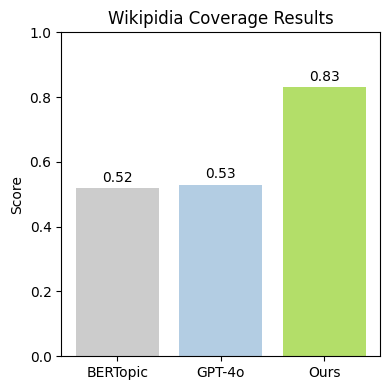

In [10]:
import matplotlib.pyplot as plt

# Data
methods = ['BERTopic', 'GPT-4o', 'Ours']
values = [0.52, 0.53, 0.83]

# Plot
plt.figure(figsize=(4, 4))
bars = plt.bar(methods, values, color=['#cccccc', '#B3CDE3', '#B3DE69'])

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', 
             ha='center', va='bottom', fontsize=10)

# Labels and title
plt.ylabel('Score')
plt.title('Wikipidia Coverage Results')

# Optional: Set y-axis limit
plt.ylim(0, 1)

# Show the plot
plt.tight_layout()
plt.show()


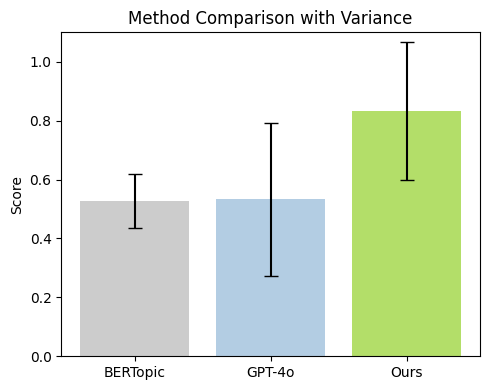

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
bertopic_samples = [0.5333, 0.6, 0.5333, 0.5333, 0.6, 0.6667, 0.4, 0.6, 0.4, 0.4]
gpt4o_samples = [0.4, 0.3333, 0.6, 0.9333, 0.2, 0.2667, 0.9333, 0.3333, 0.8, 0.5333]
ours_samples   = [0.4, 1.0, 1.0, 0.4667, 1.0, 0.6, 1.0, 0.8667, 1.0, 1.0]

# Means
means = [
    np.mean(bertopic_samples),
    np.mean(gpt4o_samples),
    np.mean(ours_samples)
]

# Standard deviations
stds = [
    np.std(bertopic_samples),
    np.std(gpt4o_samples),
    np.std(ours_samples)
]

# Labels
methods = ['BERTopic', 'GPT-4o', 'Ours']

# Plot
plt.figure(figsize=(5, 4))
bars = plt.bar(methods, means, yerr=stds, capsize=5, color=['#cccccc', '#B3CDE3', '#B3DE69'])

# Add value labels
# for bar, mean in zip(bars, means):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
#              f'{mean:.2f}', ha='center', va='bottom', fontsize=10)

# Axis labels and title
plt.ylabel('Score')
plt.title('Method Comparison with Variance')

# Optional: Set y-axis limits
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()
